# Capacity prediction

### Notebook 3: EDA
In this notebook we load the final dataset and perform an EDA on it.

**Author:** ACG  
**Date:** `2024/06`  
**Version:** 1.0  

---

### Table of Contents
1. [Categorical](#categorical)
2. [Numerical](#numerical)
3. [Correlations](#correlations)

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from utils.eda_utils import outliers_to_nan, distinct_values,fillna_on_skewness
from utils.properties import *

## Load dataset and data analysis

In [2]:
df = pd.read_csv(SECTORS_DATASET_2, sep=';')
pd.set_option('display.max_columns', None)
df.head(5)

,level_type,atcunit_code,sector_code,atc_type,sector_area,sector_perimeter,num_vertices,centroid_lat,centroid_lon,capacity,date_from,date_to,lowest_bound,highest_bound,ground,ceiling,from_ground_to_ceiling,volume_with_steps,volume_lowest_highest,volume_airblocks_avg,num_airblocks_avg,num_fluxes,all_attitudesIN,all_attitudesOUT,attitude_cruise_cruise,attitude_cruise_descend_comb,attitude_cruise_climb_comb,attitude_decent_descend,attitude_climb_climb,attitude_descend_climb_comb,sum_nFlights,max_nFlights,avg_nFlights,median_nFlights,std_nFlights,percentile25_nFlights,percentile75_nFlights,sum_avgTimeInRoute,max_avgTimeInRoute,median_avgTimeInRoute,std_avgTimeInRoute,sum_avgTimeInRoute_divided_num_flight,percentile25_avgTimeInRoute,percentile75_avgTimeInRoute,all_latIN_fluxes,all_lngIN_fluxes,all_latOUT_fluxes,all_lngOUT_fluxes,avg_latIN_fluxes,avg_lngIN_fluxes,avg_latOUT_fluxes,avg_lngOUT_fluxes,num_interacting_fluxes,num_interacting_fluxes_type_0,num_interacting_fluxes_type_1,num_interacting_fluxes_type_2,num_interacting_fluxes_type_3,avg_interacting_type,median_interacting_type,max_num_flights_interacting_fluxes_type_1,avg_num_flights_interacting_fluxes_type_1,median_num_flights_interacting_fluxes_type_1,std_num_flights_interacting_fluxes_type_1,percentile25_num_flights_interacting_fluxes_type_1,percentile75_num_flights_interacting_fluxes_type_1,max_num_flights_interacting_fluxes_type_2,avg_num_flights_interacting_fluxes_type_2,median_num_flights_interacting_fluxes_type_2,std_num_flights_interacting_fluxes_type_2,percentile25_num_flights_interacting_fluxes_type_2,percentile75_num_flights_interacting_fluxes_type_2,max_num_flights_interacting_fluxes_type_3,avg_num_flights_interacting_fluxes_type_3,median_num_flights_interacting_fluxes_type_3,std_num_flights_interacting_fluxes_type_3,percentile25_num_flights_interacting_fluxes_type_3,percentile75_num_flights_interacting_fluxes_type_3,max_avg_time_route_type_1_combined,sum_avg_time_route_type_1_divided_num_flight_combined,median_avg_time_route_type_1_combined,std_avg_time_route_type_1_combined,percentile25_avg_time_route_type_1_combined,percentile75_avg_time_route_type_1_combined,max_avg_time_route_type_2_combined,sum_avg_time_route_type_2_divided_num_flight_combined,median_avg_time_route_type_2_combined,std_avg_time_route_type_2_combined,percentile25_avg_time_route_type_2_combined,percentile75_avg_time_route_type_2_combined,max_avg_time_route_type_3_combined,sum_avg_time_route_type_3_divided_num_flight_combined,median_avg_time_route_type_3_combined,std_avg_time_route_type_3_combined,percentile25_avg_time_route_type_3_combined,percentile75_avg_time_route_type_3_combined,max_complexity_type_None,sum_complexity_type_None,median_complexity_type_None,std_complexity_type_None,percentile25_complexity_type_None,percentile75_complexity_type_None,max_complexity_type_1,sum_complexity_type_1,median_complexity_type_1,std_complexity_type_1,percentile25_complexity_type_1,percentile75_complexity_type_1,max_complexity_type_2,sum_complexity_type_2,median_complexity_type_2,std_complexity_type_2,percentile25_complexity_type_2,percentile75_complexity_type_2,max_complexity_type_3,sum_complexity_type_3,median_complexity_type_3,std_complexity_type_3,percentile25_complexity_type_3,percentile75_complexity_type_3,max_harmonic_complexity_type_None,sum_harmonic_complexity_type_None,median_harmonic_complexity_type_None,std_harmonic_complexity_type_None,percentile25_harmonic_complexity_type_None,percentile75_harmonic_complexity_type_None,max_harmonic_complexity_type_1,sum_harmonic_complexity_type_1,median_harmonic_complexity_type_1,std_harmonic_complexity_type_1,percentile25_harmonic_complexity_type_1,percentile75_harmonic_complexity_type_1,max_harmonic_complexity_type_2,sum_harmonic_complexity_type_2,median_harmonic_complexity_type_2,std_harmonic_complexity_type_2,percentile25_harmonic_complexity_type_2,percentile75_harmonic_complexity_type_2,max_harmonic_complexity_type_3,sum_harmonic_complexity_type_3,median

In [3]:
print(f"Number of observations: {df.shape[0]}")
print(f"Number of variables: {df.shape[1]}")
variables = df.columns.tolist()

Number of observations: 588
Number of variables: 190


In [4]:
target = 'capacity'
df_target = df[target]
df_target.describe()

count    588.000000
mean      32.005102
std        7.193479
min       15.000000
25%       26.000000
50%       32.000000
75%       37.000000
max       53.000000
Name: capacity, dtype: float64

We can drop the variable *level_type* because all observations are already grouped by sector, airblocks data is already included in variables like *lowest/highest_bound* and *volume_airblocks_avg*, so it adds no value.

In [5]:
df.drop('level_type',axis=1,inplace=True)

## Categorical data <a id="categorical"></a>

In this section we will make sure all qualitative variables are imported correctly as objects, they are all sufficiently represented and that there are no encoded NaN values.

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
df_categorical = df.select_dtypes(include=['object']).columns.tolist()
print(len(df_categorical))
df_categorical

11


['atcunit_code',
 'sector_code',
 'atc_type',
 'date_from',
 'date_to',
 'all_attitudesIN',
 'all_attitudesOUT',
 'all_latIN_fluxes',
 'all_lngIN_fluxes',
 'all_latOUT_fluxes',
 'all_lngOUT_fluxes']

Los códigos OACI corresponden a las siguientes areas de control:
- GCCC = Canarias 
- LEBL = Barcelona TMA
- LECB = Barcelona Ruta Este/Oeste
- LEMD = Madrid TMA
- LECM = Madrid Ruta 1/2
- LECL = Valencia APP
- LECP = Palma APP
- LECS = Sevilla TMA
- LEMG = Málaga APP

 Para poder introducirlas en el modelo sucesivamente, se van a codificar de la siguiente manera:
1. GCCC
2. LEBL
3. LECB
4. LEMD
5. LECM
6. LECL
7. LECP
8. LECS
9. LEMG

In [8]:
atc_list = df['atcunit_code'].unique().tolist()
print(atc_list)

# apply label encoding
le = LabelEncoder()
df['atcunit_code'] = le.fit_transform(df['atcunit_code'])
print(df['atcunit_code'].unique().tolist())

['GCCC', 'LEBL', 'LECB', 'LECL', 'LECM', 'LECP', 'LECS', 'LEMD', 'LEMG']
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [9]:
# apply ohe
df['is_tma'] = df['atc_type'].replace(['Aproximación','Área'], [1,0]) # 1 if TMA, 0 if route
# eliminamos columna original
df = df.drop(['atc_type'],axis=1)

In [10]:
sector_list = df['sector_code'].unique().tolist()
print(f"Number of unique sectors: {len(sector_list)}")

Number of unique sectors: 320


Verificamos cuantos sectores tiene bajo supervisión cada ATC

In [11]:
df.groupby('atcunit_code')['sector_code'].count()

atcunit_code
0     92
1    198
2     56
3     20
4     48
5     67
6     15
7     87
8      5
Name: sector_code, dtype: int64

Podemos observar como la mayoria de los sectores tienen al menos 2 configuraciones distintas a lo largo del periodo de observación, con un máximo de 4. Sin embargo muchos no han cambiado a lo largo de varios años.

In [12]:
pd.set_option('display.max_rows', None)
df['sector_code'].head(10).value_counts()

sector_code
GCCCACW    3
GCCCCES    3
GCCCAAC    2
GCCCCW4    2
Name: count, dtype: int64

In [13]:
# use label encoding for sector_code
le = LabelEncoder()
df['sector_code'] = le.fit_transform(df['sector_code'])

### Dates

We cannot feed into a model datetimes, so we tranform the date columns into numeric variables that can be handled easier by the model.

In [14]:
print(df['date_from'].dtype)
print(df['date_to'].dtype)

object
object


In [15]:
date_from = df['date_from'].min()
date_to = df['date_to'].max()
print(f"Periodo observable [{date_from} - {date_to}]")

Periodo observable [2013-01-01 - 2024-02-22]


In [16]:
# all unique date periods
df[['date_from', 'date_to']].drop_duplicates().sort_values(by='date_from')

,date_from,date_to
496,2013-01-01,2022-04-21
532,2014-10-16,2022-04-21
46,2014-11-13,2022-01-21
60,2014-12-11,2022-01-21
503,2015-03-05,2022-04-21
346,2015-05-28,2022-03-24
290,2015-06-25,2022-03-24
344,2015-07-23,2022-03-24
403,2016-03-31,2022-04-21
430,2016-08-22,2022-06-16


In [17]:
df['date_from'].dtype

dtype('O')

In [18]:
df['date_from'] = pd.to_datetime(df['date_from'])
df['date_to'] = pd.to_datetime(df['date_to'])
df['duration_days'] = df['date_to'] - df['date_from']
df['duration_days'] = df['duration_days'].dt.days

df['year_from'] = df['date_from'].dt.year
df['month_from'] = df['date_from'].dt.month
df['day_from'] = df['date_from'].dt.dayofweek

df['year_to'] = df['date_to'].dt.year
df['month_to'] = df['date_to'].dt.month
df['day_to'] = df['date_to'].dt.dayofweek

df = df.drop(['date_from','date_to'], axis=1)

In [19]:
df.head(3)

,atcunit_code,sector_code,sector_area,sector_perimeter,num_vertices,centroid_lat,centroid_lon,capacity,lowest_bound,highest_bound,ground,ceiling,from_ground_to_ceiling,volume_with_steps,volume_lowest_highest,volume_airblocks_avg,num_airblocks_avg,num_fluxes,all_attitudesIN,all_attitudesOUT,attitude_cruise_cruise,attitude_cruise_descend_comb,attitude_cruise_climb_comb,attitude_decent_descend,attitude_climb_climb,attitude_descend_climb_comb,sum_nFlights,max_nFlights,avg_nFlights,median_nFlights,std_nFlights,percentile25_nFlights,percentile75_nFlights,sum_avgTimeInRoute,max_avgTimeInRoute,median_avgTimeInRoute,std_avgTimeInRoute,sum_avgTimeInRoute_divided_num_flight,percentile25_avgTimeInRoute,percentile75_avgTimeInRoute,all_latIN_fluxes,all_lngIN_fluxes,all_latOUT_fluxes,all_lngOUT_fluxes,avg_latIN_fluxes,avg_lngIN_fluxes,avg_latOUT_fluxes,avg_lngOUT_fluxes,num_interacting_fluxes,num_interacting_fluxes_type_0,num_interacting_fluxes_type_1,num_interacting_fluxes_type_2,num_interacting_fluxes_type_3,avg_interacting_type,median_interacting_type,max_num_flights_interacting_fluxes_type_1,avg_num_flights_interacting_fluxes_type_1,median_num_flights_interacting_fluxes_type_1,std_num_flights_interacting_fluxes_type_1,percentile25_num_flights_interacting_fluxes_type_1,percentile75_num_flights_interacting_fluxes_type_1,max_num_flights_interacting_fluxes_type_2,avg_num_flights_interacting_fluxes_type_2,median_num_flights_interacting_fluxes_type_2,std_num_flights_interacting_fluxes_type_2,percentile25_num_flights_interacting_fluxes_type_2,percentile75_num_flights_interacting_fluxes_type_2,max_num_flights_interacting_fluxes_type_3,avg_num_flights_interacting_fluxes_type_3,median_num_flights_interacting_fluxes_type_3,std_num_flights_interacting_fluxes_type_3,percentile25_num_flights_interacting_fluxes_type_3,percentile75_num_flights_interacting_fluxes_type_3,max_avg_time_route_type_1_combined,sum_avg_time_route_type_1_divided_num_flight_combined,median_avg_time_route_type_1_combined,std_avg_time_route_type_1_combined,percentile25_avg_time_route_type_1_combined,percentile75_avg_time_route_type_1_combined,max_avg_time_route_type_2_combined,sum_avg_time_route_type_2_divided_num_flight_combined,median_avg_time_route_type_2_combined,std_avg_time_route_type_2_combined,percentile25_avg_time_route_type_2_combined,percentile75_avg_time_route_type_2_combined,max_avg_time_route_type_3_combined,sum_avg_time_route_type_3_divided_num_flight_combined,median_avg_time_route_type_3_combined,std_avg_time_route_type_3_combined,percentile25_avg_time_route_type_3_combined,percentile75_avg_time_route_type_3_combined,max_complexity_type_None,sum_complexity_type_None,median_complexity_type_None,std_complexity_type_None,percentile25_complexity_type_None,percentile75_complexity_type_None,max_complexity_type_1,sum_complexity_type_1,median_complexity_type_1,std_complexity_type_1,percentile25_complexity_type_1,percentile75_complexity_type_1,max_complexity_type_2,sum_complexity_type_2,median_complexity_type_2,std_complexity_type_2,percentile25_complexity_type_2,percentile75_complexity_type_2,max_complexity_type_3,sum_complexity_type_3,median_complexity_type_3,std_complexity_type_3,percentile25_complexity_type_3,percentile75_complexity_type_3,max_harmonic_complexity_type_None,sum_harmonic_complexity_type_None,median_harmonic_complexity_type_None,std_harmonic_complexity_type_None,percentile25_harmonic_complexity_type_None,percentile75_harmonic_complexity_type_None,max_harmonic_complexity_type_1,sum_harmonic_complexity_type_1,median_harmonic_complexity_type_1,std_harmonic_complexity_type_1,percentile25_harmonic_complexity_type_1,percentile75_harmonic_complexity_type_1,max_harmonic_complexity_type_2,sum_harmonic_complexity_type_2,median_harmonic_complexity_type_2,std_harmonic_complexity_type_2,percentile25_harmonic_complexity_type_2,percentile75_harmonic_complexity_type_2,max_harmonic_complexity_type_3,sum_harmonic_complexity_type_3,median_harmonic_complexity_type_3,std_harmon

We can drop attitudes and coordinates here. We don't want too many categorical variables and also these would make the model excessively complex.

In [20]:
# drop attitudes and coordinates
df.drop(columns=['all_attitudesIN','all_attitudesOUT','all_latIN_fluxes', 'all_lngIN_fluxes', 'all_latOUT_fluxes', 'all_lngOUT_fluxes'], axis=1, inplace=True)

In [21]:
df.dtypes

atcunit_code                                               int32
sector_code                                                int32
sector_area                                              float64
sector_perimeter                                         float64
num_vertices                                               int64
centroid_lat                                             float64
centroid_lon                                             float64
capacity                                                   int64
lowest_bound                                               int64
highest_bound                                              int64
ground                                                     int64
ceiling                                                    int64
from_ground_to_ceiling                                     int64
volume_with_steps                                          int64
volume_lowest_highest                                    float64
volume_airblocks_avg     

Some categorical data is being treated as numerical, these are actually booleans such as: approximation_route, volume_with_steps, atc_type_area etc. We need to change their type

In [22]:
# transform categories from numerical to obj
numerical_errata = ['sector_code','atcunit_code','ground','ceiling','from_ground_to_ceiling',
                    'volume_with_steps','is_tma',
                    'month_from','month_to','day_from','day_to']
print(df[numerical_errata].dtypes)
for variable in numerical_errata:
    df[variable] = df[variable].astype(str)
df[numerical_errata].dtypes

sector_code               int32
atcunit_code              int32
ground                    int64
ceiling                   int64
from_ground_to_ceiling    int64
volume_with_steps         int64
is_tma                    int64
month_from                int32
month_to                  int32
day_from                  int32
day_to                    int32
dtype: object


sector_code               object
atcunit_code              object
ground                    object
ceiling                   object
from_ground_to_ceiling    object
volume_with_steps         object
is_tma                    object
month_from                object
month_to                  object
day_from                  object
day_to                    object
dtype: object

In [23]:
df.head(3)

,atcunit_code,sector_code,sector_area,sector_perimeter,num_vertices,centroid_lat,centroid_lon,capacity,lowest_bound,highest_bound,ground,ceiling,from_ground_to_ceiling,volume_with_steps,volume_lowest_highest,volume_airblocks_avg,num_airblocks_avg,num_fluxes,attitude_cruise_cruise,attitude_cruise_descend_comb,attitude_cruise_climb_comb,attitude_decent_descend,attitude_climb_climb,attitude_descend_climb_comb,sum_nFlights,max_nFlights,avg_nFlights,median_nFlights,std_nFlights,percentile25_nFlights,percentile75_nFlights,sum_avgTimeInRoute,max_avgTimeInRoute,median_avgTimeInRoute,std_avgTimeInRoute,sum_avgTimeInRoute_divided_num_flight,percentile25_avgTimeInRoute,percentile75_avgTimeInRoute,avg_latIN_fluxes,avg_lngIN_fluxes,avg_latOUT_fluxes,avg_lngOUT_fluxes,num_interacting_fluxes,num_interacting_fluxes_type_0,num_interacting_fluxes_type_1,num_interacting_fluxes_type_2,num_interacting_fluxes_type_3,avg_interacting_type,median_interacting_type,max_num_flights_interacting_fluxes_type_1,avg_num_flights_interacting_fluxes_type_1,median_num_flights_interacting_fluxes_type_1,std_num_flights_interacting_fluxes_type_1,percentile25_num_flights_interacting_fluxes_type_1,percentile75_num_flights_interacting_fluxes_type_1,max_num_flights_interacting_fluxes_type_2,avg_num_flights_interacting_fluxes_type_2,median_num_flights_interacting_fluxes_type_2,std_num_flights_interacting_fluxes_type_2,percentile25_num_flights_interacting_fluxes_type_2,percentile75_num_flights_interacting_fluxes_type_2,max_num_flights_interacting_fluxes_type_3,avg_num_flights_interacting_fluxes_type_3,median_num_flights_interacting_fluxes_type_3,std_num_flights_interacting_fluxes_type_3,percentile25_num_flights_interacting_fluxes_type_3,percentile75_num_flights_interacting_fluxes_type_3,max_avg_time_route_type_1_combined,sum_avg_time_route_type_1_divided_num_flight_combined,median_avg_time_route_type_1_combined,std_avg_time_route_type_1_combined,percentile25_avg_time_route_type_1_combined,percentile75_avg_time_route_type_1_combined,max_avg_time_route_type_2_combined,sum_avg_time_route_type_2_divided_num_flight_combined,median_avg_time_route_type_2_combined,std_avg_time_route_type_2_combined,percentile25_avg_time_route_type_2_combined,percentile75_avg_time_route_type_2_combined,max_avg_time_route_type_3_combined,sum_avg_time_route_type_3_divided_num_flight_combined,median_avg_time_route_type_3_combined,std_avg_time_route_type_3_combined,percentile25_avg_time_route_type_3_combined,percentile75_avg_time_route_type_3_combined,max_complexity_type_None,sum_complexity_type_None,median_complexity_type_None,std_complexity_type_None,percentile25_complexity_type_None,percentile75_complexity_type_None,max_complexity_type_1,sum_complexity_type_1,median_complexity_type_1,std_complexity_type_1,percentile25_complexity_type_1,percentile75_complexity_type_1,max_complexity_type_2,sum_complexity_type_2,median_complexity_type_2,std_complexity_type_2,percentile25_complexity_type_2,percentile75_complexity_type_2,max_complexity_type_3,sum_complexity_type_3,median_complexity_type_3,std_complexity_type_3,percentile25_complexity_type_3,percentile75_complexity_type_3,max_harmonic_complexity_type_None,sum_harmonic_complexity_type_None,median_harmonic_complexity_type_None,std_harmonic_complexity_type_None,percentile25_harmonic_complexity_type_None,percentile75_harmonic_complexity_type_None,max_harmonic_complexity_type_1,sum_harmonic_complexity_type_1,median_harmonic_complexity_type_1,std_harmonic_complexity_type_1,percentile25_harmonic_complexity_type_1,percentile75_harmonic_complexity_type_1,max_harmonic_complexity_type_2,sum_harmonic_complexity_type_2,median_harmonic_complexity_type_2,std_harmonic_complexity_type_2,percentile25_harmonic_complexity_type_2,percentile75_harmonic_complexity_type_2,max_harmonic_complexity_type_3,sum_harmonic_complexity_type_3,median_harmonic_complexity_type_3,std_harmonic_complexity_type_3,percentile25_harmonic_complexity_type_3,percentile75_harmonic_complexity_type_3,ma

## Numerical data <a id="numerical"></a>

In [24]:
df_numerical = df.select_dtypes(include=['int32','int64','float32','float64']).columns.tolist()
df[df_numerical].describe().round(decimals=2)

,sector_area,sector_perimeter,num_vertices,centroid_lat,centroid_lon,capacity,lowest_bound,highest_bound,volume_lowest_highest,volume_airblocks_avg,num_airblocks_avg,num_fluxes,attitude_cruise_cruise,attitude_cruise_descend_comb,attitude_cruise_climb_comb,attitude_decent_descend,attitude_climb_climb,attitude_descend_climb_comb,sum_nFlights,max_nFlights,avg_nFlights,median_nFlights,std_nFlights,percentile25_nFlights,percentile75_nFlights,sum_avgTimeInRoute,max_avgTimeInRoute,median_avgTimeInRoute,std_avgTimeInRoute,sum_avgTimeInRoute_divided_num_flight,percentile25_avgTimeInRoute,percentile75_avgTimeInRoute,avg_latIN_fluxes,avg_lngIN_fluxes,avg_latOUT_fluxes,avg_lngOUT_fluxes,num_interacting_fluxes,num_interacting_fluxes_type_0,num_interacting_fluxes_type_1,num_interacting_fluxes_type_2,num_interacting_fluxes_type_3,avg_interacting_type,median_interacting_type,max_num_flights_interacting_fluxes_type_1,avg_num_flights_interacting_fluxes_type_1,median_num_flights_interacting_fluxes_type_1,std_num_flights_interacting_fluxes_type_1,percentile25_num_flights_interacting_fluxes_type_1,percentile75_num_flights_interacting_fluxes_type_1,max_num_flights_interacting_fluxes_type_2,avg_num_flights_interacting_fluxes_type_2,median_num_flights_interacting_fluxes_type_2,std_num_flights_interacting_fluxes_type_2,percentile25_num_flights_interacting_fluxes_type_2,percentile75_num_flights_interacting_fluxes_type_2,max_num_flights_interacting_fluxes_type_3,avg_num_flights_interacting_fluxes_type_3,median_num_flights_interacting_fluxes_type_3,std_num_flights_interacting_fluxes_type_3,percentile25_num_flights_interacting_fluxes_type_3,percentile75_num_flights_interacting_fluxes_type_3,max_avg_time_route_type_1_combined,sum_avg_time_route_type_1_divided_num_flight_combined,median_avg_time_route_type_1_combined,std_avg_time_route_type_1_combined,percentile25_avg_time_route_type_1_combined,percentile75_avg_time_route_type_1_combined,max_avg_time_route_type_2_combined,sum_avg_time_route_type_2_divided_num_flight_combined,median_avg_time_route_type_2_combined,std_avg_time_route_type_2_combined,percentile25_avg_time_route_type_2_combined,percentile75_avg_time_route_type_2_combined,max_avg_time_route_type_3_combined,sum_avg_time_route_type_3_divided_num_flight_combined,median_avg_time_route_type_3_combined,std_avg_time_route_type_3_combined,percentile25_avg_time_route_type_3_combined,percentile75_avg_time_route_type_3_combined,max_complexity_type_None,sum_complexity_type_None,median_complexity_type_None,std_complexity_type_None,percentile25_complexity_type_None,percentile75_complexity_type_None,max_complexity_type_1,sum_complexity_type_1,median_complexity_type_1,std_complexity_type_1,percentile25_complexity_type_1,percentile75_complexity_type_1,max_complexity_type_2,sum_complexity_type_2,median_complexity_type_2,std_complexity_type_2,percentile25_complexity_type_2,percentile75_complexity_type_2,max_complexity_type_3,sum_complexity_type_3,median_complexity_type_3,std_complexity_type_3,percentile25_complexity_type_3,percentile75_complexity_type_3,max_harmonic_complexity_type_None,sum_harmonic_complexity_type_None,median_harmonic_complexity_type_None,std_harmonic_complexity_type_None,percentile25_harmonic_complexity_type_None,percentile75_harmonic_complexity_type_None,max_harmonic_complexity_type_1,sum_harmonic_complexity_type_1,median_harmonic_complexity_type_1,std_harmonic_complexity_type_1,percentile25_harmonic_complexity_type_1,percentile75_harmonic_complexity_type_1,max_harmonic_complexity_type_2,sum_harmonic_complexity_type_2,median_harmonic_complexity_type_2,std_harmonic_complexity_type_2,percentile25_harmonic_complexity_type_2,percentile75_harmonic_complexity_type_2,max_harmonic_complexity_type_3,sum_harmonic_complexity_type_3,median_harmonic_complexity_type_3,std_harmonic_complexity_type_3,percentile25_harmonic_complexity_type_3,percentile75_harmonic_complexity_type_3,max_complexity,sum_complexity,median_complexity,std_complexity,percentile25_complex

In [25]:
# Analyze numerical data distinct values, identify potential categorical data
distinct_values(df)

,variable,distinct values
0,sector_area,440
1,sector_perimeter,440
2,num_vertices,73
3,centroid_lat,240
4,centroid_lon,255
5,capacity,31
6,lowest_bound,8
7,highest_bound,22
8,volume_lowest_highest,469
9,volume_airblocks_avg,562


In [26]:
print(df['avg_ent_w1'].mean())

0.010974978509960648


The entries in the 1 minute window average less than 1, we can assume they won't hold much weight into the final model and drop them here. 

In [27]:
df.drop(['avg_ent_w1','Q25_ent_w1','median_ent_w1','Q75_ent_w1'], axis=1, inplace=True)

### Outliers and NaN

In [28]:
# separate features and target
df_features = df.drop([target], axis=1)
features_num = df_features.select_dtypes(include=['int32','int64','float32','float64']).columns.tolist()
features_cat = df_features.select_dtypes(include=['object','datetime64[ns]']).columns.tolist()
df_features.head(3)

,atcunit_code,sector_code,sector_area,sector_perimeter,num_vertices,centroid_lat,centroid_lon,lowest_bound,highest_bound,ground,ceiling,from_ground_to_ceiling,volume_with_steps,volume_lowest_highest,volume_airblocks_avg,num_airblocks_avg,num_fluxes,attitude_cruise_cruise,attitude_cruise_descend_comb,attitude_cruise_climb_comb,attitude_decent_descend,attitude_climb_climb,attitude_descend_climb_comb,sum_nFlights,max_nFlights,avg_nFlights,median_nFlights,std_nFlights,percentile25_nFlights,percentile75_nFlights,sum_avgTimeInRoute,max_avgTimeInRoute,median_avgTimeInRoute,std_avgTimeInRoute,sum_avgTimeInRoute_divided_num_flight,percentile25_avgTimeInRoute,percentile75_avgTimeInRoute,avg_latIN_fluxes,avg_lngIN_fluxes,avg_latOUT_fluxes,avg_lngOUT_fluxes,num_interacting_fluxes,num_interacting_fluxes_type_0,num_interacting_fluxes_type_1,num_interacting_fluxes_type_2,num_interacting_fluxes_type_3,avg_interacting_type,median_interacting_type,max_num_flights_interacting_fluxes_type_1,avg_num_flights_interacting_fluxes_type_1,median_num_flights_interacting_fluxes_type_1,std_num_flights_interacting_fluxes_type_1,percentile25_num_flights_interacting_fluxes_type_1,percentile75_num_flights_interacting_fluxes_type_1,max_num_flights_interacting_fluxes_type_2,avg_num_flights_interacting_fluxes_type_2,median_num_flights_interacting_fluxes_type_2,std_num_flights_interacting_fluxes_type_2,percentile25_num_flights_interacting_fluxes_type_2,percentile75_num_flights_interacting_fluxes_type_2,max_num_flights_interacting_fluxes_type_3,avg_num_flights_interacting_fluxes_type_3,median_num_flights_interacting_fluxes_type_3,std_num_flights_interacting_fluxes_type_3,percentile25_num_flights_interacting_fluxes_type_3,percentile75_num_flights_interacting_fluxes_type_3,max_avg_time_route_type_1_combined,sum_avg_time_route_type_1_divided_num_flight_combined,median_avg_time_route_type_1_combined,std_avg_time_route_type_1_combined,percentile25_avg_time_route_type_1_combined,percentile75_avg_time_route_type_1_combined,max_avg_time_route_type_2_combined,sum_avg_time_route_type_2_divided_num_flight_combined,median_avg_time_route_type_2_combined,std_avg_time_route_type_2_combined,percentile25_avg_time_route_type_2_combined,percentile75_avg_time_route_type_2_combined,max_avg_time_route_type_3_combined,sum_avg_time_route_type_3_divided_num_flight_combined,median_avg_time_route_type_3_combined,std_avg_time_route_type_3_combined,percentile25_avg_time_route_type_3_combined,percentile75_avg_time_route_type_3_combined,max_complexity_type_None,sum_complexity_type_None,median_complexity_type_None,std_complexity_type_None,percentile25_complexity_type_None,percentile75_complexity_type_None,max_complexity_type_1,sum_complexity_type_1,median_complexity_type_1,std_complexity_type_1,percentile25_complexity_type_1,percentile75_complexity_type_1,max_complexity_type_2,sum_complexity_type_2,median_complexity_type_2,std_complexity_type_2,percentile25_complexity_type_2,percentile75_complexity_type_2,max_complexity_type_3,sum_complexity_type_3,median_complexity_type_3,std_complexity_type_3,percentile25_complexity_type_3,percentile75_complexity_type_3,max_harmonic_complexity_type_None,sum_harmonic_complexity_type_None,median_harmonic_complexity_type_None,std_harmonic_complexity_type_None,percentile25_harmonic_complexity_type_None,percentile75_harmonic_complexity_type_None,max_harmonic_complexity_type_1,sum_harmonic_complexity_type_1,median_harmonic_complexity_type_1,std_harmonic_complexity_type_1,percentile25_harmonic_complexity_type_1,percentile75_harmonic_complexity_type_1,max_harmonic_complexity_type_2,sum_harmonic_complexity_type_2,median_harmonic_complexity_type_2,std_harmonic_complexity_type_2,percentile25_harmonic_complexity_type_2,percentile75_harmonic_complexity_type_2,max_harmonic_complexity_type_3,sum_harmonic_complexity_type_3,median_harmonic_complexity_type_3,std_harmonic_complexity_type_3,percentile25_harmonic_complexity_type_3,percentile75_harmonic_complexity_type_3,max_complex

In [29]:
# check if there is any variable with 50% or more of NaN
nan_per_variable = df_features.isna().sum() / len(df_features)
nan_per_variable

atcunit_code                                             0.000000
sector_code                                              0.000000
sector_area                                              0.000000
sector_perimeter                                         0.000000
num_vertices                                             0.000000
centroid_lat                                             0.000000
centroid_lon                                             0.000000
lowest_bound                                             0.000000
highest_bound                                            0.000000
ground                                                   0.000000
ceiling                                                  0.000000
from_ground_to_ceiling                                   0.000000
volume_with_steps                                        0.000000
volume_lowest_highest                                    0.000000
volume_airblocks_avg                                     0.000000
num_airblo

For those variables that have a considerable amount of nan, we can impute statistics measures into those. Because there aren't many observations to begin with,  it's not ideal to drop nans, even if they are just less than 20%.
However, using the average as imputation might not make sense for some variables like -> num_fluxes, because it should be important to see outliers and the sectors with the least traffic. 

Because of the high variation in those variables, we will impute using the median.

In [30]:
# variables with high variation
median_imp_vars = ['num_fluxes','num_interacting_fluxes','max_complexity','sum_complexity','attitude_cruise_cruise','attitude_cruise_descend_comb',
                 'attitude_cruise_climb_comb','attitude_decent_descend','attitude_climb_climb','attitude_descend_climb_comb',
                 'median_complexity','std_complexity','max_harmonic_complexity','median_harmonic_complexity','std_harmonic_complexity']

# variables that represents an average
avg_imp_vars = ['sum_nFlights','avg_nFlights','sum_avgTimeInRoute','sum_avgTimeInRoute_divided_num_flight']

In [31]:
for var in median_imp_vars:
    df_features[var].fillna(df_features[var].median(), inplace=True)
    
for var in avg_imp_vars:
    df_features[var].fillna(df_features[var].mean(), inplace=True)

In [32]:
# check for observations with 50% or more NaN
df_features.isna().sum()
# most observations have columns Num_fluxes to occ NaN, however some only have NaNs from num_interacting_fluxes (for example sectors GCCCCW4,LEBL12XE)

atcunit_code                                               0
sector_code                                                0
sector_area                                                0
sector_perimeter                                           0
num_vertices                                               0
centroid_lat                                               0
centroid_lon                                               0
lowest_bound                                               0
highest_bound                                              0
ground                                                     0
ceiling                                                    0
from_ground_to_ceiling                                     0
volume_with_steps                                          0
volume_lowest_highest                                      0
volume_airblocks_avg                                       0
num_airblocks_avg                                          0
num_fluxes              

# Correlations between variables <a id="correlations"></a>

In [33]:
import numpy as np
from utils.eda_utils import v_cramer

In [34]:
numerical_vars = df_features.select_dtypes(include=['int32','int64','float32','float64']).columns.tolist()

### Spearman's matrix

Measures the monotonic relationship between two variables, it's better suited for non-linear relationships.

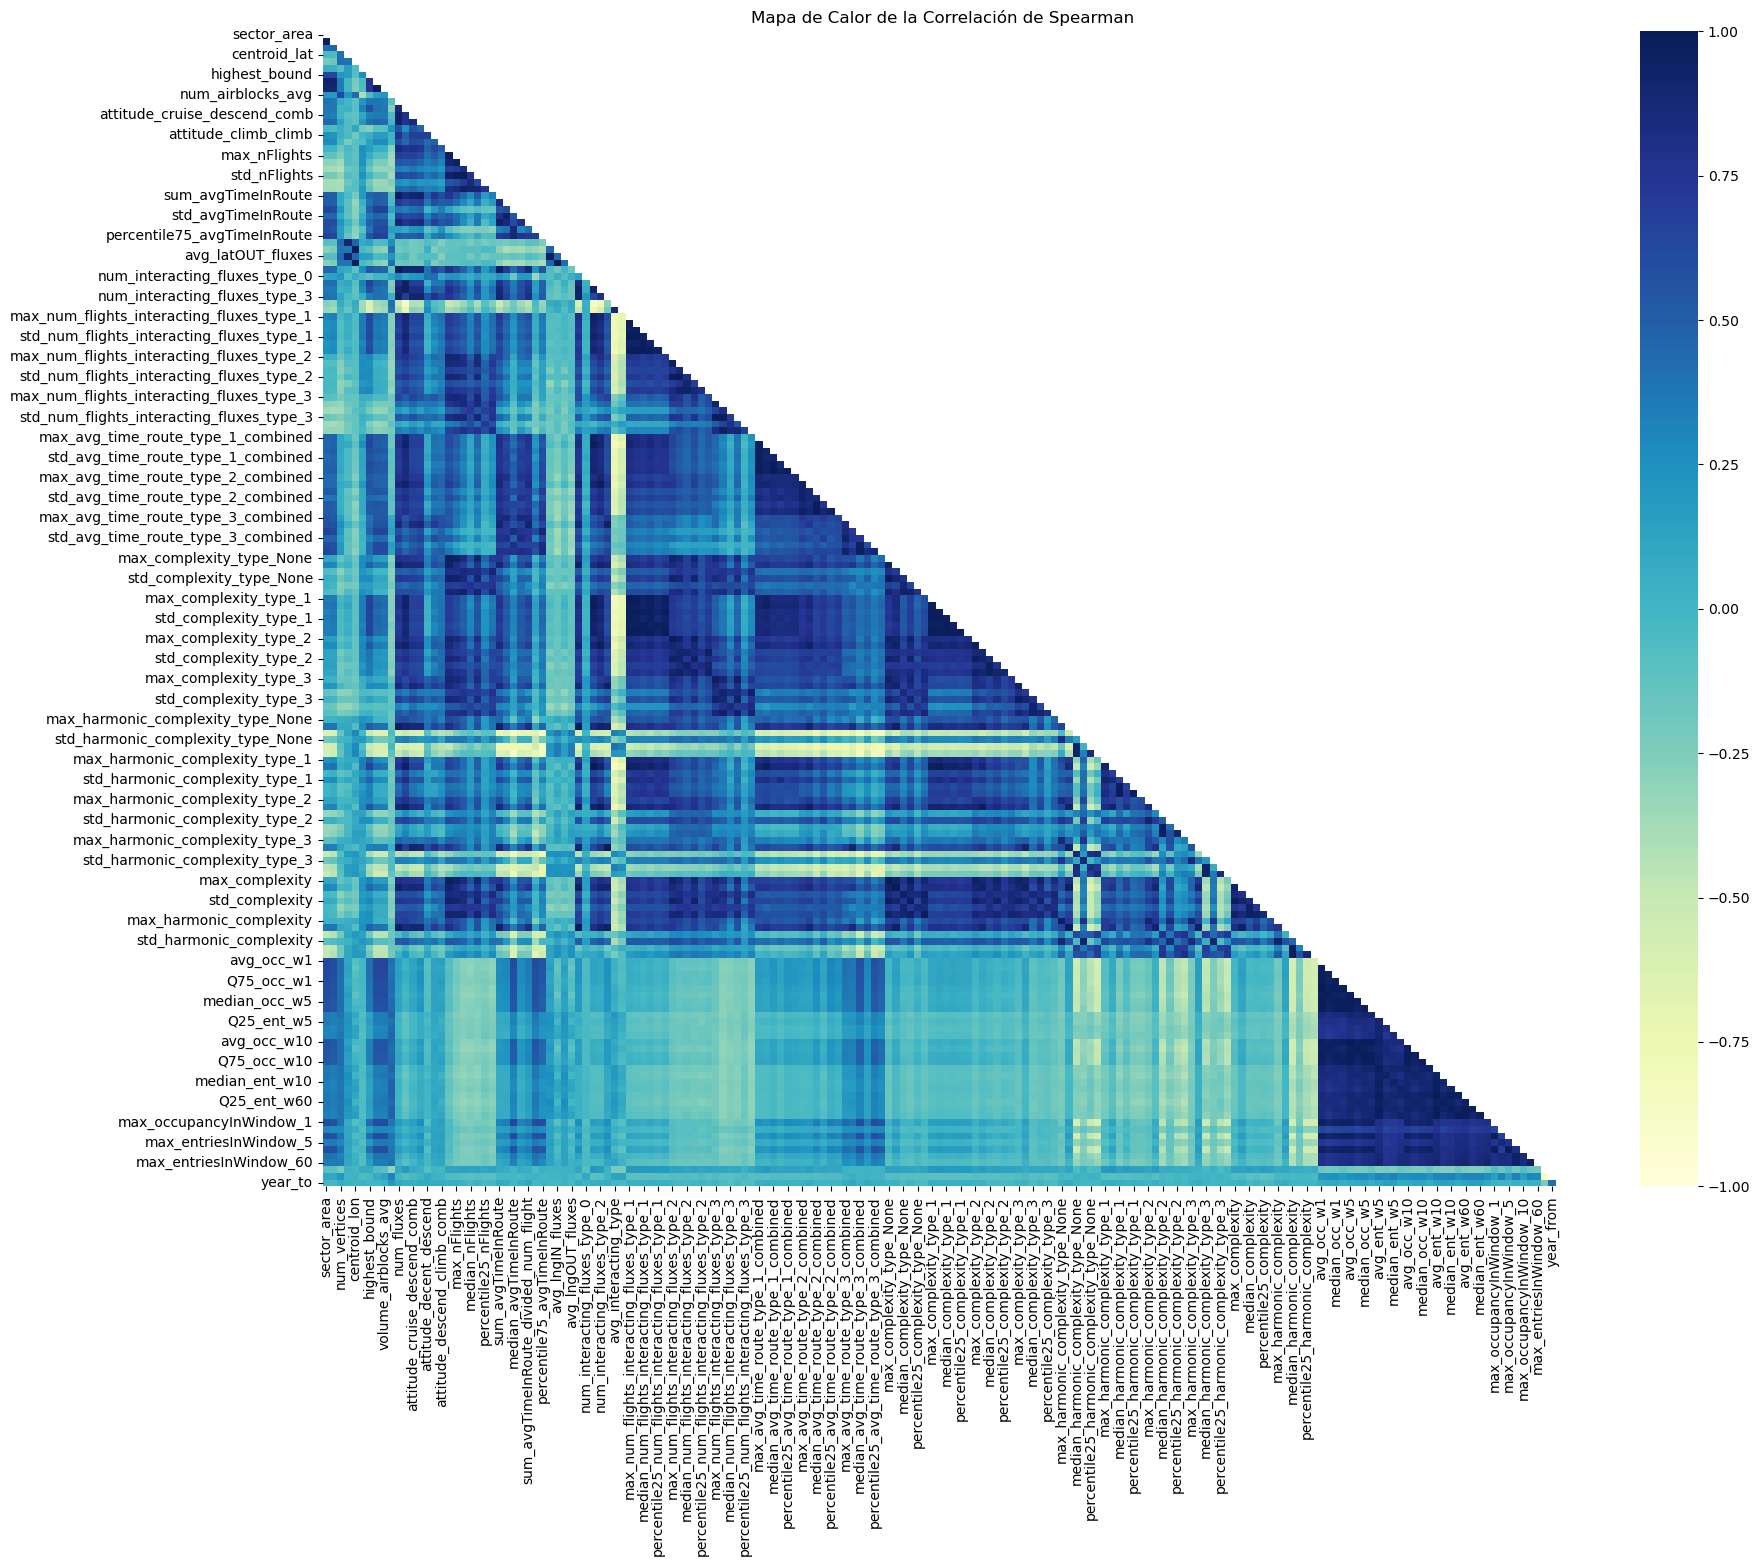

In [35]:
spearman_matrix = df[numerical_vars].corr(method='spearman')
plt.figure(figsize=(20, 15), dpi=100)
mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))
sbn.heatmap(spearman_matrix, mask=mask, annot=True, 
            fmt='.2f', cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Mapa de Calor de la Correlación de Spearman')
plt.savefig('../plots/spearman_correlation_heatmap.png') 
plt.show()

In [36]:
spearman_matrix.loc['sector_area', 'sector_perimeter']

0.9758819008774465

## Feature Reduction

In [37]:
# drop reduntant features
drop_high_corr = ['sector_perimeter','num_fluxes','volume_lowest_highest','highest_bound','volume_airblocks_avg',
                  'sum_nFlights', # avg_nFlights aporta mejor información
                  'num_fluxes', 'sum_avgTimeInRoute','num_interacting_fluxes',
                  'centroid_lat','centroid_lon','sum_avgTimeInRoute_divided_num_flight', 'num_vertices',
                  'max_complexity','sum_complexity','percentile25_complexity','percentile75_complexity','sum_harmonic_complexity',
                  'percentile25_harmonic_complexity','percentile75_harmonic_complexity',
                  'attitude_cruise_descend_comb', 'attitude_cruise_climb_comb', 'attitude_decent_descend','attitude_climb_climb','attitude_descend_climb_comb',
                  'avg_occ_w1','Q25_occ_w1','Q75_occ_w1','median_occ_w1','median_occ_w5','Q25_occ_w5','Q75_occ_w5','Q25_ent_w5','median_ent_w5',
                  'median_occ_w10','Q25_occ_w10','Q75_occ_w10','Q25_ent_w10','median_ent_w10','Q75_ent_w10',
                  'Q25_ent_w60','median_ent_w60','Q75_ent_w60',
                  'Q75_ent_w5','avg_ent_w10','max_occupancyInWindow_1','max_occupancyInWindow_5',
                  'max_entriesInWindow_1','max_entriesInWindow_5',
                 'max_nFlights','median_nFlights',
                'std_nFlights','percentile25_nFlights','percentile75_nFlights','max_avgTimeInRoute',
               'median_avgTimeInRoute','std_avgTimeInRoute','percentile25_avgTimeInRoute','percentile75_avgTimeInRoute',
               'avg_latIN_fluxes','avg_lngIN_fluxes','avg_latOUT_fluxes','avg_lngOUT_fluxes',
               'num_interacting_fluxes_type_0','num_interacting_fluxes_type_1','num_interacting_fluxes_type_2','num_interacting_fluxes_type_3',
                'avg_interacting_type','median_interacting_type','max_num_flights_interacting_fluxes_type_1','avg_num_flights_interacting_fluxes_type_1',
                'median_num_flights_interacting_fluxes_type_1','std_num_flights_interacting_fluxes_type_1','percentile25_num_flights_interacting_fluxes_type_1',
                'percentile75_num_flights_interacting_fluxes_type_1','max_num_flights_interacting_fluxes_type_2','avg_num_flights_interacting_fluxes_type_2',
                'median_num_flights_interacting_fluxes_type_2','std_num_flights_interacting_fluxes_type_2','percentile25_num_flights_interacting_fluxes_type_2','percentile75_num_flights_interacting_fluxes_type_2',
                'max_num_flights_interacting_fluxes_type_3','avg_num_flights_interacting_fluxes_type_3','median_num_flights_interacting_fluxes_type_3','std_num_flights_interacting_fluxes_type_3',
                'percentile25_num_flights_interacting_fluxes_type_3','percentile75_num_flights_interacting_fluxes_type_3','max_avg_time_route_type_1_combined','sum_avg_time_route_type_1_divided_num_flight_combined',
                'median_avg_time_route_type_1_combined','std_avg_time_route_type_1_combined','percentile25_avg_time_route_type_1_combined','percentile75_avg_time_route_type_1_combined',
                'max_avg_time_route_type_2_combined','sum_avg_time_route_type_2_divided_num_flight_combined','median_avg_time_route_type_2_combined','std_avg_time_route_type_2_combined',
                'percentile25_avg_time_route_type_2_combined','percentile75_avg_time_route_type_2_combined','max_avg_time_route_type_3_combined','sum_avg_time_route_type_3_divided_num_flight_combined',
                'median_avg_time_route_type_3_combined','std_avg_time_route_type_3_combined','percentile25_avg_time_route_type_3_combined','percentile75_avg_time_route_type_3_combined','max_complexity_type_None',
                'sum_complexity_type_None','median_complexity_type_None','std_complexity_type_None','percentile25_complexity_type_None','percentile75_complexity_type_None','max_complexity_type_1',
                'sum_complexity_type_1','median_complexity_type_1','std_complexity_type_1','percentile25_complexity_type_1','percentile75_complexity_type_1','max_complexity_type_2',
                'sum_complexity_type_2','median_complexity_type_2','std_complexity_type_2','percentile25_complexity_type_2','percentile75_complexity_type_2','max_complexity_type_3',
                'sum_complexity_type_3','median_complexity_type_3','std_complexity_type_3','percentile25_complexity_type_3','percentile75_complexity_type_3',
                'max_harmonic_complexity_type_None','sum_harmonic_complexity_type_None','median_harmonic_complexity_type_None','std_harmonic_complexity_type_None','percentile25_harmonic_complexity_type_None',
                'percentile75_harmonic_complexity_type_None','max_harmonic_complexity_type_1','sum_harmonic_complexity_type_1','median_harmonic_complexity_type_1',
                'std_harmonic_complexity_type_1','percentile25_harmonic_complexity_type_1','percentile75_harmonic_complexity_type_1','max_harmonic_complexity_type_2',
                'sum_harmonic_complexity_type_2','median_harmonic_complexity_type_2','std_harmonic_complexity_type_2','percentile25_harmonic_complexity_type_2',
                'percentile75_harmonic_complexity_type_2','max_harmonic_complexity_type_3','sum_harmonic_complexity_type_3','median_harmonic_complexity_type_3',
                'std_harmonic_complexity_type_3','percentile25_harmonic_complexity_type_3','percentile75_harmonic_complexity_type_3']

df_features = df_features.drop(columns=drop_high_corr, axis=1)

## Correlations with target

<Figure size 1800x1500 with 0 Axes>

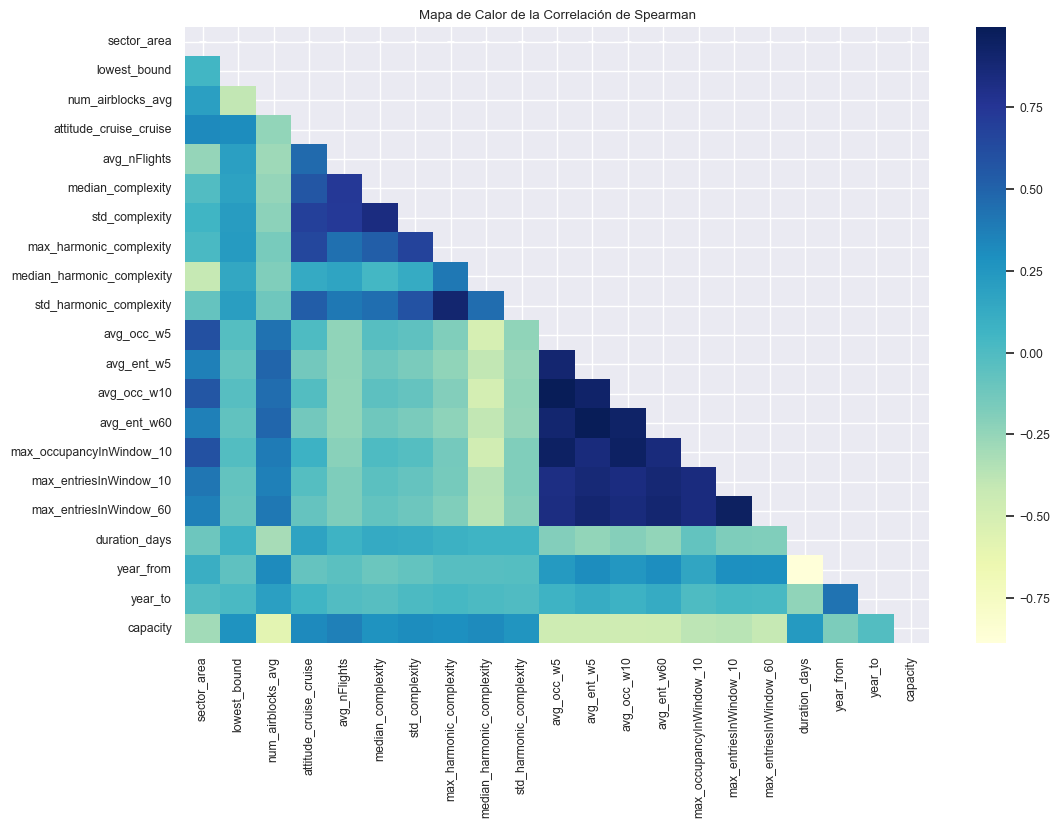

In [38]:
numerical_reduced = df_features.select_dtypes(include=['int32','int64','float32','float64']).columns.tolist()

df_with_target = pd.concat([df_features[numerical_reduced], df_target], axis=1)
spearman_matrix = df_with_target.corr(method='spearman')
plt.figure(figsize=(18, 15), dpi=100)
mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sbn.set(font_scale=0.8)
sbn.heatmap(spearman_matrix, mask=mask, annot=True, 
            fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title('Mapa de Calor de la Correlación de Spearman')
plt.savefig('../plots/spearman_correlation_heatmap_2.png') 
plt.show()

In [39]:
spearman_matrix['capacity']

sector_area                  -0.298265
lowest_bound                  0.275371
num_airblocks_avg            -0.589172
attitude_cruise_cruise        0.320349
avg_nFlights                  0.369903
median_complexity             0.277890
std_complexity                0.307989
max_harmonic_complexity       0.295525
median_harmonic_complexity    0.316453
std_harmonic_complexity       0.261291
avg_occ_w5                   -0.457321
avg_ent_w5                   -0.460867
avg_occ_w10                  -0.462817
avg_ent_w60                  -0.457224
max_occupancyInWindow_10     -0.383451
max_entriesInWindow_10       -0.367858
max_entriesInWindow_60       -0.411706
duration_days                 0.232407
year_from                    -0.167893
year_to                      -0.013792
capacity                      1.000000
Name: capacity, dtype: float64

In [40]:
# specific correlations
spearman_matrix.loc['avg_ent_w5', 'capacity']

-0.4608669811641543

### Transformations

Transforming numerical input variables can improve their correlations with the target.

In [41]:
from utils.eda_utils import optimized_transf_cont,apply_transf

In [42]:
df_features.head(3)

,atcunit_code,sector_code,sector_area,lowest_bound,ground,ceiling,from_ground_to_ceiling,volume_with_steps,num_airblocks_avg,attitude_cruise_cruise,avg_nFlights,median_complexity,std_complexity,max_harmonic_complexity,median_harmonic_complexity,std_harmonic_complexity,avg_occ_w5,avg_ent_w5,avg_occ_w10,avg_ent_w60,max_occupancyInWindow_10,max_entriesInWindow_10,max_entriesInWindow_60,is_tma,duration_days,year_from,month_from,day_from,year_to,month_to,day_to
0,0,0,2.356833e+10,0,1,0,0,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,3.571429,0.666667,4.904762,14.666667,15,10,40,0,162,2021,8,3,2022,1,4
1,0,0,2.356695e+10,0,1,0,0,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,4.538226,0.972477,6.012232,17.000000,22,12,44,0,326,2022,1,4,2022,12,1
2,0,1,4.967764e+10,0,1,0,0,1,3.0,2.0,243.758621,1487976.0,2.824313e+06,0.029999,0.014448,0.003,1.761905,0.047619,2.380952,7.714286,10,8,24,0,162,2021,8,3,2022,1,4


In [43]:
df_features[numerical_reduced].isna().sum()

sector_area                   0
lowest_bound                  0
num_airblocks_avg             0
attitude_cruise_cruise        0
avg_nFlights                  0
median_complexity             0
std_complexity                0
max_harmonic_complexity       0
median_harmonic_complexity    0
std_harmonic_complexity       0
avg_occ_w5                    0
avg_ent_w5                    0
avg_occ_w10                   0
avg_ent_w60                   0
max_occupancyInWindow_10      0
max_entriesInWindow_10        0
max_entriesInWindow_60        0
duration_days                 0
year_from                     0
year_to                       0
dtype: int64

In [44]:
# apply transformations on selected features
df_features_transf = apply_transf(df_features[numerical_reduced], df_target)
df_features_transf.head(3)

,logx_sector_area,pow2x_lowest_bound,sqrtx_num_airblocks_avg,sqrtx_attitude_cruise_cruise,4rtx_avg_nFlights,4rtx_median_complexity,sqrtx_std_complexity,4rtx_max_harmonic_complexity,4rtx_median_harmonic_complexity,sqrtx_std_harmonic_complexity,sqrtx_avg_occ_w5,x_avg_ent_w5,sqrtx_avg_occ_w10,x_avg_ent_w60,sqrtx_max_occupancyInWindow_10,sqrtx_max_entriesInWindow_10,sqrtx_max_entriesInWindow_60,4rtx_duration_days,sqrtx_year_from,pow4x_year_to
0,-1.253211,7.427661e-10,0.010042,0.368849,1.239579,1.324235,1.890816,0.770914,1.111259,0.832357,1.002066,0.808069,1.029412,1.196342,0.825190,0.848172,0.897239,0.632084,1.764858,1.148608e-17
1,-1.253271,7.427661e-10,0.010042,0.368849,1.239579,1.324235,1.890816,0.770914,1.111259,0.832357,1.129568,1.178679,1.148026,1.435085,1.129880,1.003540,0.966344,0.771817,1.871905,1.148608e-17
2,-0.490960,7.427661e-10,0.381708,0.301200,0.722736,0.775368,0.559473,0.650827,0.924201,0.455986,0.703875,0.057847,0.686374,0.484988,0.505417,0.657038,0.538433,0.632084,1.764858,1.148608e-17


In [45]:
# merge features with transformations
df_transf = pd.concat([df_features[numerical_reduced], df_features_transf], axis=1)
df_transf.head(3)

,sector_area,lowest_bound,num_airblocks_avg,attitude_cruise_cruise,avg_nFlights,median_complexity,std_complexity,max_harmonic_complexity,median_harmonic_complexity,std_harmonic_complexity,avg_occ_w5,avg_ent_w5,avg_occ_w10,avg_ent_w60,max_occupancyInWindow_10,max_entriesInWindow_10,max_entriesInWindow_60,duration_days,year_from,year_to,logx_sector_area,pow2x_lowest_bound,sqrtx_num_airblocks_avg,sqrtx_attitude_cruise_cruise,4rtx_avg_nFlights,4rtx_median_complexity,sqrtx_std_complexity,4rtx_max_harmonic_complexity,4rtx_median_harmonic_complexity,sqrtx_std_harmonic_complexity,sqrtx_avg_occ_w5,x_avg_ent_w5,sqrtx_avg_occ_w10,x_avg_ent_w60,sqrtx_max_occupancyInWindow_10,sqrtx_max_entriesInWindow_10,sqrtx_max_entriesInWindow_60,4rtx_duration_days,sqrtx_year_from,pow4x_year_to
0,2.356833e+10,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,3.571429,0.666667,4.904762,14.666667,15,10,40,162,2021,2022,-1.253211,7.427661e-10,0.010042,0.368849,1.239579,1.324235,1.890816,0.770914,1.111259,0.832357,1.002066,0.808069,1.029412,1.196342,0.825190,0.848172,0.897239,0.632084,1.764858,1.148608e-17
1,2.356695e+10,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,4.538226,0.972477,6.012232,17.000000,22,12,44,326,2022,2022,-1.253271,7.427661e-10,0.010042,0.368849,1.239579,1.324235,1.890816,0.770914,1.111259,0.832357,1.129568,1.178679,1.148026,1.435085,1.129880,1.003540,0.966344,0.771817,1.871905,1.148608e-17
2,4.967764e+10,0,3.0,2.0,243.758621,1487976.0,2.824313e+06,0.029999,0.014448,0.003,1.761905,0.047619,2.380952,7.714286,10,8,24,162,2021,2022,-0.490960,7.427661e-10,0.381708,0.301200,0.722736,0.775368,0.559473,0.650827,0.924201,0.455986,0.703875,0.057847,0.686374,0.484988,0.505417,0.657038,0.538433,0.632084,1.764858,1.148608e-17


In [46]:
# merge target back
df_transf = pd.concat([df_transf, df_target], axis=1)
df_transf.head(3)

,sector_area,lowest_bound,num_airblocks_avg,attitude_cruise_cruise,avg_nFlights,median_complexity,std_complexity,max_harmonic_complexity,median_harmonic_complexity,std_harmonic_complexity,avg_occ_w5,avg_ent_w5,avg_occ_w10,avg_ent_w60,max_occupancyInWindow_10,max_entriesInWindow_10,max_entriesInWindow_60,duration_days,year_from,year_to,logx_sector_area,pow2x_lowest_bound,sqrtx_num_airblocks_avg,sqrtx_attitude_cruise_cruise,4rtx_avg_nFlights,4rtx_median_complexity,sqrtx_std_complexity,4rtx_max_harmonic_complexity,4rtx_median_harmonic_complexity,sqrtx_std_harmonic_complexity,sqrtx_avg_occ_w5,x_avg_ent_w5,sqrtx_avg_occ_w10,x_avg_ent_w60,sqrtx_max_occupancyInWindow_10,sqrtx_max_entriesInWindow_10,sqrtx_max_entriesInWindow_60,4rtx_duration_days,sqrtx_year_from,pow4x_year_to,capacity
0,2.356833e+10,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,3.571429,0.666667,4.904762,14.666667,15,10,40,162,2021,2022,-1.253211,7.427661e-10,0.010042,0.368849,1.239579,1.324235,1.890816,0.770914,1.111259,0.832357,1.002066,0.808069,1.029412,1.196342,0.825190,0.848172,0.897239,0.632084,1.764858,1.148608e-17,38
1,2.356695e+10,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,4.538226,0.972477,6.012232,17.000000,22,12,44,326,2022,2022,-1.253271,7.427661e-10,0.010042,0.368849,1.239579,1.324235,1.890816,0.770914,1.111259,0.832357,1.129568,1.178679,1.148026,1.435085,1.129880,1.003540,0.966344,0.771817,1.871905,1.148608e-17,38
2,4.967764e+10,0,3.0,2.0,243.758621,1487976.0,2.824313e+06,0.029999,0.014448,0.003,1.761905,0.047619,2.380952,7.714286,10,8,24,162,2021,2022,-0.490960,7.427661e-10,0.381708,0.301200,0.722736,0.775368,0.559473,0.650827,0.924201,0.455986,0.703875,0.057847,0.686374,0.484988,0.505417,0.657038,0.538433,0.632084,1.764858,1.148608e-17,35


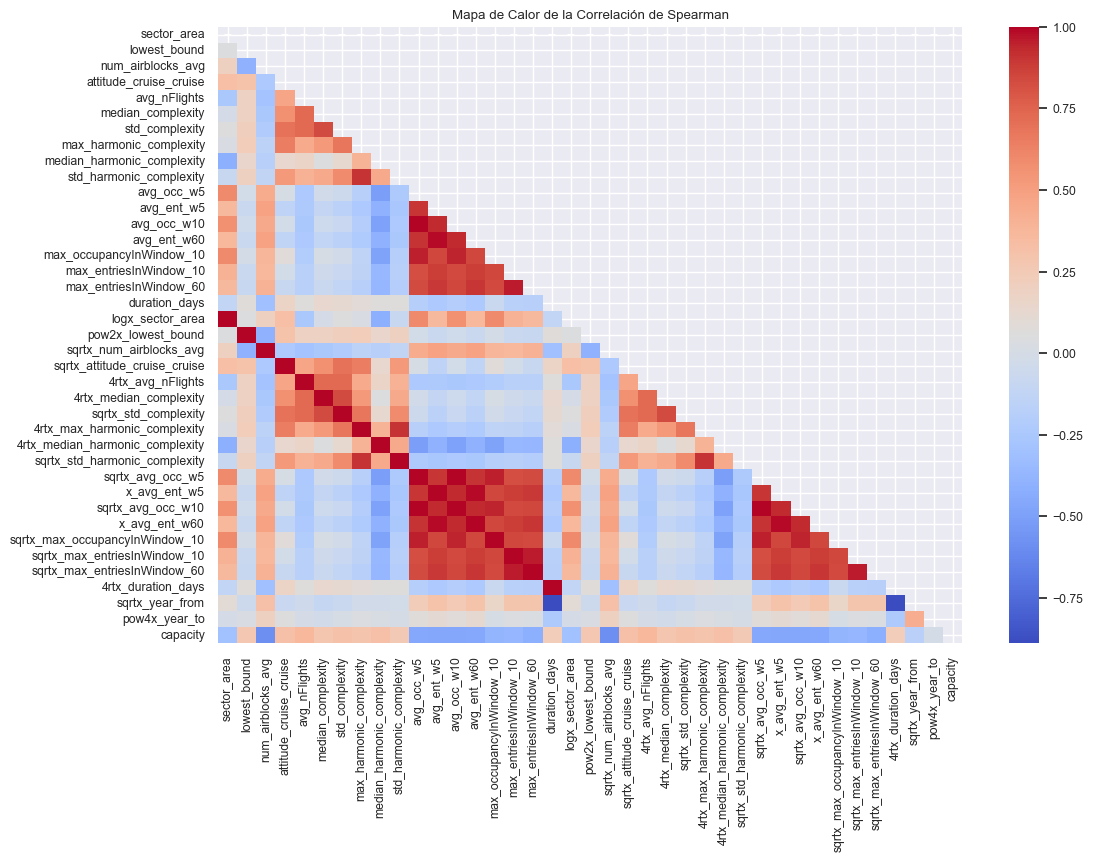

In [47]:
input_transf = df_transf.select_dtypes(include=['int64','float64']).columns.tolist()
spearman_matrix = df_transf[input_transf].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sbn.set(font_scale=0.8)
sbn.heatmap(spearman_matrix, mask=mask, annot=True, 
            fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de la Correlación de Spearman')
plt.show()

In [48]:
spearman_matrix['capacity']

sector_area                       -0.298265
lowest_bound                       0.275371
num_airblocks_avg                 -0.589172
attitude_cruise_cruise             0.320349
avg_nFlights                       0.369903
median_complexity                  0.277890
std_complexity                     0.307989
max_harmonic_complexity            0.295525
median_harmonic_complexity         0.316453
std_harmonic_complexity            0.261291
avg_occ_w5                        -0.457321
avg_ent_w5                        -0.460867
avg_occ_w10                       -0.462817
avg_ent_w60                       -0.457224
max_occupancyInWindow_10          -0.383451
max_entriesInWindow_10            -0.367858
max_entriesInWindow_60            -0.411706
duration_days                      0.232407
logx_sector_area                  -0.298265
pow2x_lowest_bound                 0.275371
sqrtx_num_airblocks_avg           -0.589172
sqrtx_attitude_cruise_cruise       0.320349
4rtx_avg_nFlights               

The mathematical transformations did not provide a significant improvement to the correlation with the target.

## Correlation with categorical features

In [49]:
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [50]:
#df_categorical = df.select_dtypes(include=['object']).columns.tolist()
features_cat = df_features.select_dtypes(include=['object']).columns.tolist()
print(features_cat)

['atcunit_code', 'sector_code', 'ground', 'ceiling', 'from_ground_to_ceiling', 'volume_with_steps', 'is_tma', 'month_from', 'day_from', 'month_to', 'day_to']


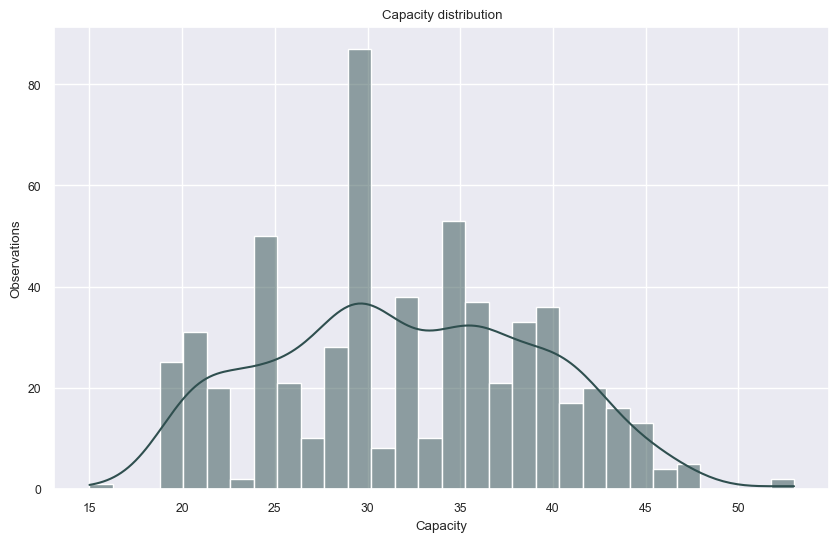

In [51]:
plt.figure(figsize=(10, 6))
sbn.histplot(df['capacity'], kde=True, bins=30, color='darkslategrey')
plt.title('Capacity distribution')
plt.xlabel('Capacity')
plt.ylabel('Observations')
plt.show()

Since the target doesn't follow a normal distribution, we can use the Kruskal-Wallis H test to measure the correlations of categorical features to it.

## Kruskal-Wallis H test

In [52]:
# if non-normal distribution
from scipy.stats import kruskal

for feature in features_cat:
    groups = [df[df[feature] == level]['capacity'] for level in df[feature].unique()]
    statistic, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis test for {feature}: H-statistic = {statistic}, p-value = {p_value}")

Kruskal-Wallis test for atcunit_code: H-statistic = 142.00179352190048, p-value = 9.095328039941507e-27
Kruskal-Wallis test for sector_code: H-statistic = 587.0, p-value = 4.1284314416495384e-18
Kruskal-Wallis test for ground: H-statistic = 42.568420184522296, p-value = 6.825247641050179e-11
Kruskal-Wallis test for ceiling: H-statistic = 22.51670733516359, p-value = 2.0832381148183984e-06
Kruskal-Wallis test for from_ground_to_ceiling: H-statistic = 2.5080348333771814, p-value = 0.11326709813107187
Kruskal-Wallis test for volume_with_steps: H-statistic = 14.523836341015526, p-value = 0.00013839729386403706
Kruskal-Wallis test for is_tma: H-statistic = 41.7133840672653, p-value = 1.0568304401383133e-10
Kruskal-Wallis test for month_from: H-statistic = 70.64914456361663, p-value = 9.193624584312677e-11
Kruskal-Wallis test for day_from: H-statistic = 20.29303298229851, p-value = 0.0011009588406864401
Kruskal-Wallis test for month_to: H-statistic = 36.43912418640004, p-value = 7.0731751307

As seen from the results, most variables have a relatively high H statistic and very small p-values, which indicates their significant contribution to the target's variance. Here we should drop high p-value variables. The exceptions are **from_ground_to_ceiling** and **day_to**, since their p-value is greater than 0.05, we can safely say they do not contribute to the target's variance in a significant way, so we should drop them.

In [53]:
# drop the features with low correlations with the target
features_cat.remove('from_ground_to_ceiling')
features_cat.remove('day_to')
df_features = df_features.drop(['from_ground_to_ceiling','day_to'], axis=1)

## Save EDA

It doesn't seem like any transformation has increased the correlation with the target, so we'll use the df without them

In [54]:
df_features_final = pd.concat([df_features[numerical_reduced], df_features[features_cat]], axis=1)
df_final = pd.concat([df_features_final, df_target], axis=1)
df_final.head(5)

,sector_area,lowest_bound,num_airblocks_avg,attitude_cruise_cruise,avg_nFlights,median_complexity,std_complexity,max_harmonic_complexity,median_harmonic_complexity,std_harmonic_complexity,avg_occ_w5,avg_ent_w5,avg_occ_w10,avg_ent_w60,max_occupancyInWindow_10,max_entriesInWindow_10,max_entriesInWindow_60,duration_days,year_from,year_to,atcunit_code,sector_code,ground,ceiling,volume_with_steps,is_tma,month_from,day_from,month_to,capacity
0,2.356833e+10,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,3.571429,0.666667,4.904762,14.666667,15,10,40,162,2021,2022,0,0,1,0,0,0,8,3,1,38
1,2.356695e+10,0,1.0,3.0,2025.422222,12510402.0,3.226555e+07,0.053953,0.025025,0.010,4.538226,0.972477,6.012232,17.000000,22,12,44,326,2022,2022,0,0,1,0,0,0,1,4,12,38
2,4.967764e+10,0,3.0,2.0,243.758621,1487976.0,2.824313e+06,0.029999,0.014448,0.003,1.761905,0.047619,2.380952,7.714286,10,8,24,162,2021,2022,0,1,1,0,1,0,8,3,1,35
3,5.189257e+10,0,3.0,2.0,243.758621,1487976.0,2.824313e+06,0.029999,0.014448,0.003,2.074286,0.051429,2.760000,8.154286,12,8,28,174,2022,2022,0,1,1,0,1,0,1,4,7,35
4,5.189130e+10,0,4.5,2.0,243.758621,1487976.0,2.824313e+06,0.029999,0.014448,0.003,2.200000,0.223529,2.958824,9.923529,14,14,46,448,2022,2023,0,1,1,0,1,0,7,3,10,35


In [55]:
path_storage = f"{DATASET_FINAL}"
df_final.to_csv(path_storage, sep=";", index=False)